In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive/', force_remount=True)
!unzip -q /content/gdrive/MyDrive/Dataset.zip

Mounted at /content/gdrive/


In [3]:
image_list = [
    os.path.join(dirname, filename)
    for dirname, _, filenames in os.walk("Dataset")
    for filename in filenames
    if ".jpg" in filename
]

In [4]:
chihuahua_images = [img for img in image_list if "chihuahua" in img]
muffin_images = [img for img in image_list if "muffin" in img]
cnt_chihuahua = len(chihuahua_images)
cnt_muffin = len(muffin_images)
print(cnt_chihuahua)
print(cnt_muffin)

3199
2718


In [5]:
import pandas as pd

In [6]:

labels = [os.path.basename(os.path.dirname(img)) for img in image_list]
filepaths = [img for img in image_list]
df = pd.DataFrame({"file":filepaths, "label":labels})

In [7]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(df, test_size=0.2, random_state=100)
train, val = train_test_split(train_val, test_size=0.125, random_state=100)

print("Training set:", len(train))
print("Validation set:", len(val))
print("Test set:", len(test))

Training set: 4141
Validation set: 592
Test set: 1184


In [8]:
df

,file,label
0,Dataset/muffin/img_3_768.jpg,muffin
1,Dataset/muffin/img_1_881.jpg,muffin
2,Dataset/muffin/img_0_203.jpg,muffin
3,Dataset/muffin/img_4_100.jpg,muffin
4,Dataset/muffin/img_2_511.jpg,muffin
...,...,...
5912,Dataset/chihuahua/img_0_1196.jpg,chihuahua
5913,Dataset/chihuahua/img_4_803.jpg,chihuahua
5914,Dataset/chihuahua/img_0_596.jpg,chihuahua
5915,Dataset/chihuahua/img_2_1032.jpg,chihuahua


In [9]:
# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 16

train_gen = datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content",
    x_col="file",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    seed=100,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val,
    directory="/content",
    x_col="file",
    y_col="label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    seed=100,
    shuffle=True
)


Found 4141 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.


In [10]:
test_gen = datagen.flow_from_dataframe(
            dataframe = test,
            directory = "/content",
            seed = 100,
            x_col = "file",
            y_col = "label",
            target_size = (224,224),
            class_mode="binary",
            color_mode = "rgb",
            shuffle=False)

Found 1184 validated image filenames belonging to 2 classes.


In [11]:
print("Training set:", len(train))
print("Validation set:", len(val))
print("Test set:", len(test))

Training set: 4141
Validation set: 592
Test set: 1184


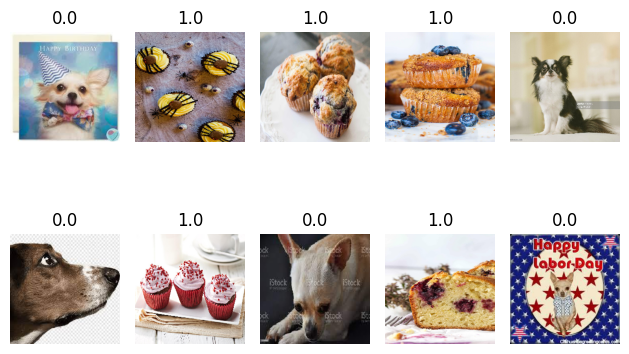

In [14]:
images, labels = train_gen.next()

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Data Augmentation**

In [15]:
aug = ImageDataGenerator(rescale=1. / 255, rotation_range=12, width_shift_range=0.4, height_shift_range=0.2, shear_range=0.1, zoom_range=0.2,
    channel_shift_range=15., horizontal_flip=True)

train_gen_aug = aug.flow_from_dataframe(
    dataframe=train,
    x_col="file",
    y_col="label",
    directory="/content",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    color_mode='rgb',
    seed=100,
    shuffle = True
)

val_gen_aug = aug.flow_from_dataframe(
    dataframe=val,
    x_col="file",
    y_col="label",
    directory="/content",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="binary",
    color_mode='rgb',
    seed=100,
    shuffle = True
)

Found 4141 validated image filenames belonging to 2 classes.
Found 592 validated image filenames belonging to 2 classes.


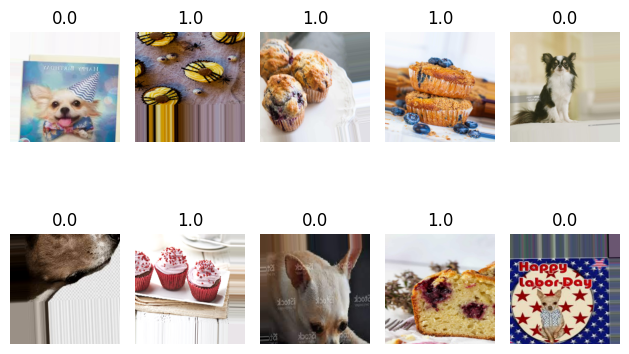

In [18]:
images, labels = train_gen_aug.next()

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
stop_early = [keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5,  start_from_epoch= 15)]

In [20]:
stop_early2 = [keras.callbacks.EarlyStopping(monitor="val_loss", patience = 3,  start_from_epoch= 15)]

# **First Model**


In [22]:
from keras.layers import MaxPooling2D

In [23]:
FirstModel = Sequential([

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(units = 64, activation = 'relu'),

    Dense(units=1, activation='sigmoid')
])

In [24]:
FirstModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [25]:
#https://deeplizard.com/learn/video/daovGOlMbT4
FirstModel.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])

In [26]:
train_steps = len(train) // batch_size
val_steps = len(val) // batch_size

In [27]:
history1 = FirstModel.fit(x=train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks = stop_early,
    steps_per_epoch = min(train_steps, 200)
)
metrics_df1 = pd.DataFrame(history1.history)

Epoch 1/50
200/200 [==============================] - 23s 89ms/step - loss: 0.5560 - accuracy: 0.7570 - val_loss: 0.4219 - val_accuracy: 0.8041
Epoch 2/50
200/200 [==============================] - 18s 88ms/step - loss: 0.3466 - accuracy: 0.8580 - val_loss: 0.3462 - val_accuracy: 0.8564
Epoch 3/50
200/200 [==============================] - 18s 88ms/step - loss: 0.2373 - accuracy: 0.9049 - val_loss: 0.3163 - val_accuracy: 0.8750
Epoch 4/50
200/200 [==============================] - 18s 87ms/step - loss: 0.1503 - accuracy: 0.9456 - val_loss: 0.4869 - val_accuracy: 0.8429
Epoch 5/50
200/200 [==============================] - 18s 89ms/step - loss: 0.0951 - accuracy: 0.9687 - val_loss: 0.4741 - val_accuracy: 0.8429
Epoch 6/50
200/200 [==============================] - 17s 87ms/step - loss: 0.0640 - accuracy: 0.9759 - val_loss: 0.4836 - val_accuracy: 0.8733
Epoch 7/50
200/200 [==============================] - 18s 88ms/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.6154 - val_accuracy:

In [28]:
metrics_df1

,loss,accuracy,val_loss,val_accuracy
0,0.555956,0.756960,0.421907,0.804054
1,0.346586,0.857992,0.346214,0.856419
2,0.237321,0.904911,0.316307,0.875000
3,0.150282,0.945574,0.486862,0.842905
4,0.095114,0.968721,0.474106,0.842905
5,0.064015,0.975915,0.483608,0.873311
6,0.023346,0.993119,0.615384,0.853041
7,0.021258,0.993431,0.659304,0.873311
8,0.016208,0.994682,0.586899,0.856419
9,0.038862,0.988114,0.685426,0.819257


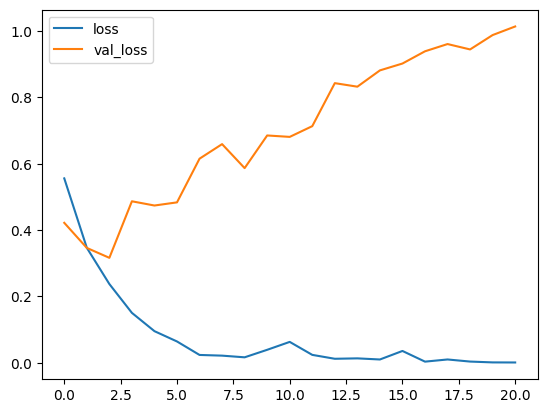

In [29]:
metrics_df1[["loss","val_loss"]].plot();

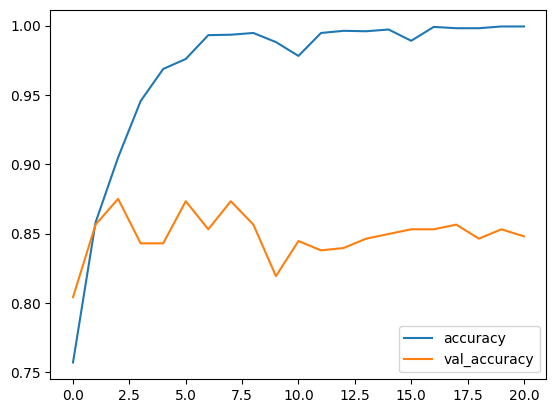

In [30]:
metrics_df1[["accuracy","val_accuracy"]].plot();

# **Second Model**

In [31]:


SecondModel = Sequential([

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),
    Dense(units = 64, activation = 'relu'),

    Dense(units=1, activation='sigmoid')
])

In [32]:
SecondModel.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])


In [33]:
history2 = SecondModel.fit(x=train_gen_aug,
    validation_data=val_gen_aug,
    epochs=50,
    callbacks = stop_early2,
    steps_per_epoch = min(train_steps, 200)

)

metrics_df2 = pd.DataFrame(history2.history)

Epoch 1/50
200/200 [==============================] - 56s 276ms/step - loss: 0.6856 - accuracy: 0.6847 - val_loss: 0.5833 - val_accuracy: 0.6959
Epoch 2/50
200/200 [==============================] - 56s 278ms/step - loss: 0.5148 - accuracy: 0.7607 - val_loss: 0.5438 - val_accuracy: 0.7382
Epoch 3/50
200/200 [==============================] - 55s 276ms/step - loss: 0.4498 - accuracy: 0.8058 - val_loss: 0.4833 - val_accuracy: 0.7889
Epoch 4/50
200/200 [==============================] - 56s 279ms/step - loss: 0.4138 - accuracy: 0.8158 - val_loss: 0.3969 - val_accuracy: 0.8209
Epoch 5/50
200/200 [==============================] - 55s 277ms/step - loss: 0.4003 - accuracy: 0.8226 - val_loss: 0.3913 - val_accuracy: 0.8226
Epoch 6/50
200/200 [==============================] - 56s 280ms/step - loss: 0.3851 - accuracy: 0.8417 - val_loss: 0.3976 - val_accuracy: 0.8260
Epoch 7/50
200/200 [==============================] - 56s 280ms/step - loss: 0.3695 - accuracy: 0.8386 - val_loss: 0.3886 - val_ac

In [34]:
metrics_df2

,loss,accuracy,val_loss,val_accuracy
0,0.685643,0.684687,0.583314,0.695946
1,0.514794,0.760713,0.543835,0.738176
2,0.449783,0.805755,0.483297,0.788851
3,0.413778,0.815765,0.396862,0.820946
4,0.400350,0.822646,0.391298,0.822635
5,0.385101,0.841727,0.397572,0.826014
6,0.369471,0.838599,0.388584,0.834459
7,0.366414,0.851110,0.397130,0.827703
8,0.375719,0.840163,0.372065,0.861486
9,0.332750,0.863309,0.328196,0.853041


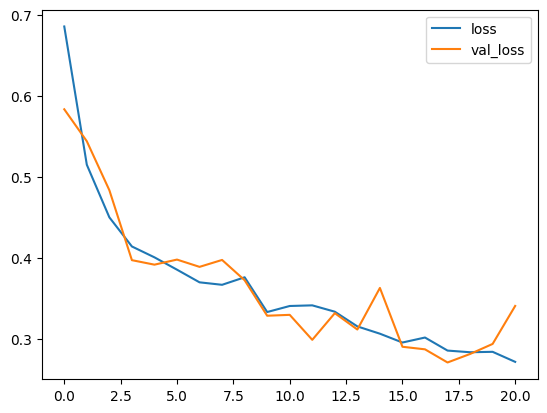

In [35]:
metrics_df2[["loss","val_loss"]].plot();

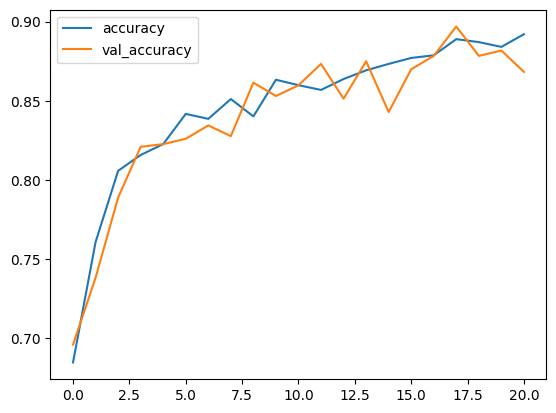

In [36]:
metrics_df2[["accuracy","val_accuracy"]].plot();

# **Third Model**

In [37]:
ThirdModel = Sequential([

    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),

    Flatten(),
    Dense(units = 64, activation = 'relu'),
    Dropout(0.3),

    Dense(units=1, activation='sigmoid')
])

ThirdModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)       

In [38]:
ThirdModel.compile(optimizer = "adam",
                   loss = "binary_crossentropy",
                   metrics = ["accuracy"])

In [39]:
history3 = ThirdModel.fit(x=train_gen_aug,
    validation_data=val_gen_aug,
    epochs=50,
    callbacks=stop_early2,
    steps_per_epoch = min(train_steps, 200)
)

metrics_df3 = pd.DataFrame(history3.history)

Epoch 1/50
200/200 [==============================] - 58s 279ms/step - loss: 0.7567 - accuracy: 0.7094 - val_loss: 0.5157 - val_accuracy: 0.7703
Epoch 2/50
200/200 [==============================] - 56s 278ms/step - loss: 0.4823 - accuracy: 0.7926 - val_loss: 0.4558 - val_accuracy: 0.8007
Epoch 3/50
200/200 [==============================] - 56s 279ms/step - loss: 0.4294 - accuracy: 0.8197 - val_loss: 0.4018 - val_accuracy: 0.8277
Epoch 4/50
200/200 [==============================] - 56s 278ms/step - loss: 0.4009 - accuracy: 0.8317 - val_loss: 0.4446 - val_accuracy: 0.8091
Epoch 5/50
200/200 [==============================] - 55s 277ms/step - loss: 0.4120 - accuracy: 0.8261 - val_loss: 0.4039 - val_accuracy: 0.8480
Epoch 6/50
200/200 [==============================] - 55s 277ms/step - loss: 0.3955 - accuracy: 0.8402 - val_loss: 0.3948 - val_accuracy: 0.8260
Epoch 7/50
200/200 [==============================] - 55s 277ms/step - loss: 0.3895 - accuracy: 0.8373 - val_loss: 0.3776 - val_ac

In [40]:
metrics_df3

,loss,accuracy,val_loss,val_accuracy
0,0.756693,0.709375,0.515735,0.770270
1,0.482336,0.792618,0.455848,0.800676
2,0.429409,0.819687,0.401816,0.827703
3,0.400861,0.831717,0.444622,0.809122
4,0.412050,0.826087,0.403890,0.847973
5,0.395456,0.840163,0.394767,0.826014
6,0.389544,0.837348,0.377590,0.834459
7,0.393222,0.827025,0.345477,0.849662
8,0.379281,0.833438,0.353815,0.849662
9,0.369833,0.852813,0.343374,0.878378


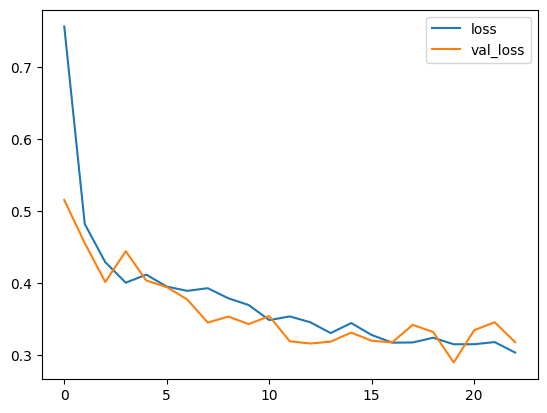

In [41]:
metrics_df3[["loss","val_loss"]].plot();

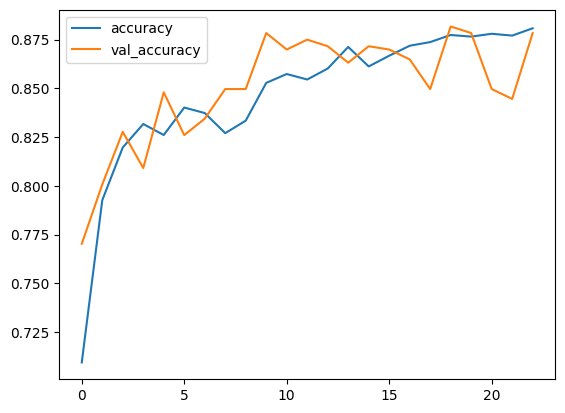

In [42]:
metrics_df3[["accuracy","val_accuracy"]].plot();

Hyper Parameter tuning


In [43]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [44]:
def model_builder(hp):
    hidden_dropout = hp.Float("dropout_hidden_layer", min_value = 0.05, max_value = 0.3, step = 0.05)
    dense_dropout = hp.Float("dropout_flatten_layer", min_value = 0.2, max_value = 0.5, step = 0.1)

    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=hp.Int("convolution_1_filters", min_value=16, max_value=64, step=16),
                                  kernel_size=(3, 3),
                                  input_shape=(224, 224, 3)))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hidden_dropout))


    model.add(keras.layers.Conv2D(filters=hp.Int("convolution_2_filters", min_value=32, max_value=128, step=32),
                                  kernel_size=(3, 3)))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hidden_dropout))



    model.add(keras.layers.Conv2D(filters=hp.Int("convolution_3_filters", min_value=64, max_value=256, step=64),
                                  kernel_size=(3, 3)))
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hidden_dropout))



    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=hp.Int("num_units", min_value=32, max_value=256, step=32),
                                 activation="relu"))
    model.add(Dropout(dense_dropout))



    model.add(keras.layers.Dense(units=1, activation="sigmoid"))


    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [45]:
tuner = kt.BayesianOptimization(model_builder, objective = "val_accuracy", max_trials = 3,
                                directory = "./gdrive/MyDrive/Muffin&Chihuahua",
                                project_name = "cnn",
                                overwrite = False)

In [46]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
dropout_hidden_layer (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.3, 'step': 0.05, 'sampling': 'linear'}
dropout_flatten_layer (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
convolution_1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
convolution_2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
convolution_3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}


In [47]:
tuner.search(train_gen_aug, epochs = 50, validation_data = val_gen_aug,
             callbacks = stop_early2, steps_per_epoch = min(train_steps, 200))

Trial 3 Complete [00h 21m 33s]
val_accuracy: 0.8986486196517944

Best val_accuracy So Far: 0.9155405163764954
Total elapsed time: 01h 02m 05s


In [48]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [49]:
best_hyperparameters.values

{'dropout_hidden_layer': 0.05,
 'dropout_flatten_layer': 0.4,
 'convolution_1_filters': 48,
 'convolution_2_filters': 96,
 'convolution_3_filters': 192,
 'num_units': 224}

In [50]:
hypermodel = tuner.hypermodel.build(best_hyperparameters)

In [51]:
history_best = hypermodel.fit(train_gen_aug,
                         epochs = 50,
                         validation_data = val_gen_aug,

                         callbacks=stop_early2
)
metrics_df = pd.DataFrame(history_best.history)

Epoch 1/50
259/259 [==============================] - 71s 270ms/step - loss: 0.7120 - accuracy: 0.5916 - val_loss: 0.6711 - val_accuracy: 0.5861
Epoch 2/50
259/259 [==============================] - 70s 271ms/step - loss: 0.5464 - accuracy: 0.7426 - val_loss: 0.4728 - val_accuracy: 0.7804
Epoch 3/50
259/259 [==============================] - 69s 267ms/step - loss: 0.4490 - accuracy: 0.8083 - val_loss: 0.3999 - val_accuracy: 0.8176
Epoch 4/50
259/259 [==============================] - 69s 265ms/step - loss: 0.4037 - accuracy: 0.8300 - val_loss: 0.4674 - val_accuracy: 0.7990
Epoch 5/50
259/259 [==============================] - 70s 269ms/step - loss: 0.3885 - accuracy: 0.8346 - val_loss: 0.4388 - val_accuracy: 0.8193
Epoch 6/50
259/259 [==============================] - 69s 267ms/step - loss: 0.3687 - accuracy: 0.8450 - val_loss: 0.3044 - val_accuracy: 0.8784
Epoch 7/50
259/259 [==============================] - 69s 266ms/step - loss: 0.3381 - accuracy: 0.8616 - val_loss: 0.3111 - val_ac

In [52]:
metrics_df = pd.DataFrame(history_best.history)

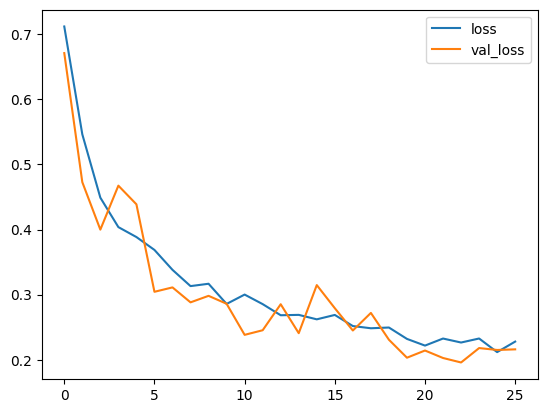

In [53]:
metrics_df[["loss","val_loss"]].plot();

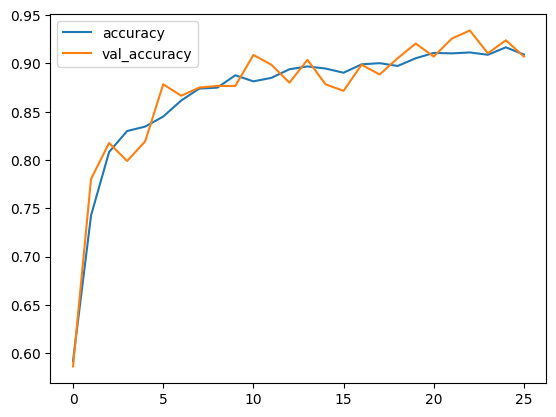

In [54]:
metrics_df[["accuracy","val_accuracy"]].plot();

# **Predictions**

In [55]:
pred = hypermodel.predict(test_gen)

37/37 [==============================] - 6s 145ms/step


In [56]:
pred

array([[4.1933730e-05],
       [9.9634570e-01],
       [6.8327404e-07],
       ...,
       [6.3282895e-01],
       [9.9840313e-01],
       [9.9999177e-01]], dtype=float32)

In [57]:
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
pred_r = [0 if val < 0.5 else 1 for val in pred]

In [58]:
from sklearn import metrics
report = metrics.classification_report(true_classes, pred_r, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

   chihuahua       0.88      0.95      0.91       606
      muffin       0.94      0.86      0.90       578

    accuracy                           0.91      1184
   macro avg       0.91      0.91      0.91      1184
weighted avg       0.91      0.91      0.91      1184



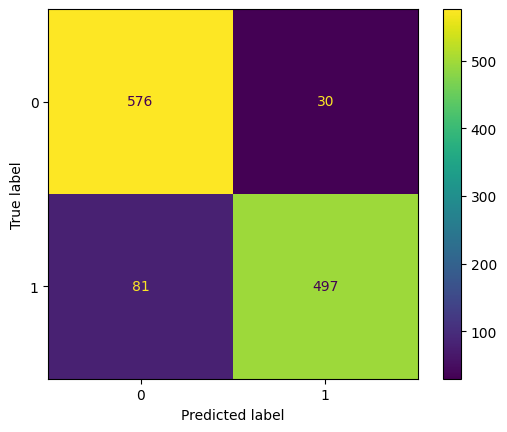

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(true_classes, pred_r)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm)

cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.show()

In [60]:
hypermodel.evaluate(test_gen)

37/37 [==============================] - 5s 148ms/step - loss: 0.2617 - accuracy: 0.9062


[0.2616957724094391, 0.90625]

ROC AUC: 0.961749


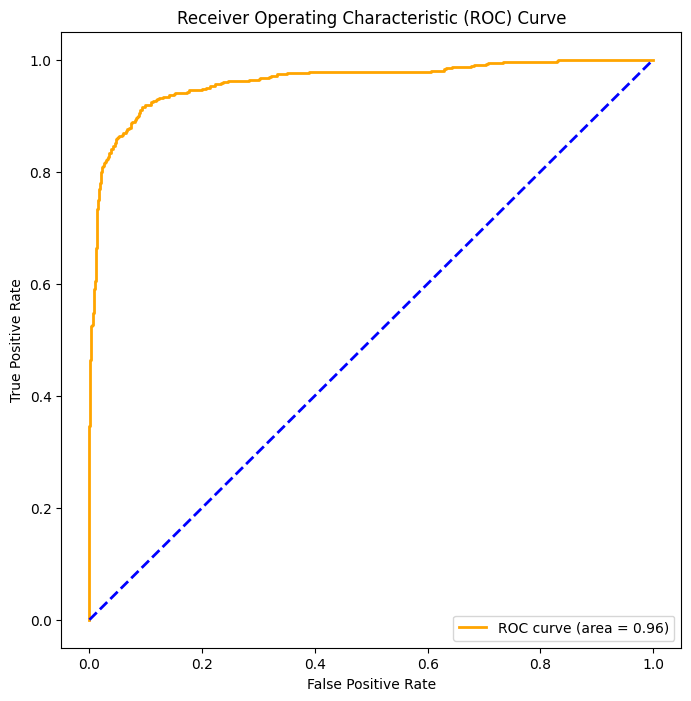

In [61]:
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = metrics.roc_curve(true_classes, pred)

auc = roc_auc_score(true_classes,pred)
print('ROC AUC: %f' % auc)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **5 Fold Cross Validation**

In [62]:
from sklearn.model_selection import KFold

Y = train[['label']]
kf = KFold(n_splits = 5, random_state = 100, shuffle = True)

In [63]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [80]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold_var = 1

for train_index, val_index in kf.split(df):
    training = df["file"][train_index]
    validation = df["file"][val_index]

    train_df = df.loc[df["file"].isin(training)]
    val_df = df.loc[df["file"].isin(validation)]

    train_data_generator = aug.flow_from_dataframe(train_df, directory="/content",
                                                    x_col="file", y_col="label",
                                                    class_mode="binary", shuffle=True, seed=100,
                                                    target_size=(224, 224))
    valid_data_generator = aug.flow_from_dataframe(val_df, directory="/content",
                                                    x_col="file", y_col="label",
                                                    class_mode="binary", shuffle=True, seed=100,
                                                    target_size=(224, 224))

    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hyperparameters)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # FIT THE MODEL
    history = model.fit(train_data_generator,
                        epochs=50,
                        callbacks=stop_early,
                        validation_data=valid_data_generator)

    # SAVE BEST MODEL
    model_path = "/content/Muffin&Chihuahua/model_" + str(fold_var) + ".h5"
    model.save(model_path)

    # LOAD BEST MODEL to evaluate the performance of the model
    if os.path.exists(model_path):
        model.load_weights(model_path)
    else:
        print("File doesn't exist")

    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names, results))

    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1


Found 4733 validated image filenames belonging to 2 classes.
Found 1184 validated image filenames belonging to 2 classes.
Epoch 1/50
148/148 [==============================] - 89s 588ms/step - loss: 0.7980 - accuracy: 0.6324 - val_loss: 0.5339 - val_accuracy: 0.7432
Epoch 2/50
148/148 [==============================] - 86s 581ms/step - loss: 0.4819 - accuracy: 0.7851 - val_loss: 0.4549 - val_accuracy: 0.8007
Epoch 3/50
148/148 [==============================] - 86s 579ms/step - loss: 0.4494 - accuracy: 0.8025 - val_loss: 0.4408 - val_accuracy: 0.8083
Epoch 4/50
148/148 [==============================] - 86s 580ms/step - loss: 0.4234 - accuracy: 0.8232 - val_loss: 0.4047 - val_accuracy: 0.8285
Epoch 5/50
148/148 [==============================] - 87s 585ms/step - loss: 0.3925 - accuracy: 0.8377 - val_loss: 0.5780 - val_accuracy: 0.7255
Epoch 6/50
148/148 [==============================] - 86s 580ms/step - loss: 0.3970 - accuracy: 0.8382 - val_loss: 0.4409 - val_accuracy: 0.8074
Epoch 7/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 17s 471ms/step - loss: 0.2368 - accuracy: 0.9096
Found 4733 validated image filenames belonging to 2 classes.
Found 1184 validated image filenames belonging to 2 classes.
Epoch 1/50
148/148 [==============================] - 88s 583ms/step - loss: 0.6594 - accuracy: 0.6903 - val_loss: 0.5082 - val_accuracy: 0.8159
Epoch 2/50
148/148 [==============================] - 86s 584ms/step - loss: 0.4861 - accuracy: 0.7864 - val_loss: 0.5582 - val_accuracy: 0.7373
Epoch 3/50
148/148 [==============================] - 86s 581ms/step - loss: 0.4233 - accuracy: 0.8136 - val_loss: 0.3956 - val_accuracy: 0.8269
Epoch 4/50
148/148 [==============================] - 86s 584ms/step - loss: 0.4075 - accuracy: 0.8284 - val_loss: 0.3705 - val_accuracy: 0.8378
Epoch 5/50
148/148 [==============================] - 87s 588ms/step - loss: 0.3642 - accuracy: 0.8487 - val_loss: 0.3330 - val_accuracy: 0.8615
Epoch 6/50
148/148 [==============================] - 86s 584ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 17s 466ms/step - loss: 0.1888 - accuracy: 0.9223
Found 4734 validated image filenames belonging to 2 classes.
Found 1183 validated image filenames belonging to 2 classes.
Epoch 1/50
148/148 [==============================] - 91s 603ms/step - loss: 0.7302 - accuracy: 0.5889 - val_loss: 0.5552 - val_accuracy: 0.7041
Epoch 2/50
148/148 [==============================] - 86s 582ms/step - loss: 0.5176 - accuracy: 0.7628 - val_loss: 0.4674 - val_accuracy: 0.7785
Epoch 3/50
148/148 [==============================] - 86s 583ms/step - loss: 0.4838 - accuracy: 0.7871 - val_loss: 0.4256 - val_accuracy: 0.8199
Epoch 4/50
148/148 [==============================] - 86s 585ms/step - loss: 0.4249 - accuracy: 0.8196 - val_loss: 0.3665 - val_accuracy: 0.8504
Epoch 5/50
148/148 [==============================] - 86s 584ms/step - loss: 0.4374 - accuracy: 0.8200 - val_loss: 0.3588 - val_accuracy: 0.8478
Epoch 6/50
148/148 [==============================] - 86s 584ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 17s 465ms/step - loss: 0.2156 - accuracy: 0.9079
Found 4734 validated image filenames belonging to 2 classes.
Found 1183 validated image filenames belonging to 2 classes.
Epoch 1/50
148/148 [==============================] - 88s 582ms/step - loss: 0.7308 - accuracy: 0.6595 - val_loss: 0.4778 - val_accuracy: 0.7718
Epoch 2/50
148/148 [==============================] - 86s 580ms/step - loss: 0.4645 - accuracy: 0.7921 - val_loss: 0.4534 - val_accuracy: 0.7946
Epoch 3/50
148/148 [==============================] - 86s 583ms/step - loss: 0.4167 - accuracy: 0.8270 - val_loss: 0.3984 - val_accuracy: 0.8233
Epoch 4/50
148/148 [==============================] - 87s 587ms/step - loss: 0.3875 - accuracy: 0.8338 - val_loss: 0.3852 - val_accuracy: 0.8369
Epoch 5/50
148/148 [==============================] - 86s 583ms/step - loss: 0.3509 - accuracy: 0.8549 - val_loss: 0.3382 - val_accuracy: 0.8588
Epoch 6/50
148/148 [==============================] - 86s 584ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 17s 471ms/step - loss: 0.2368 - accuracy: 0.9036
Found 4734 validated image filenames belonging to 2 classes.
Found 1183 validated image filenames belonging to 2 classes.
Epoch 1/50
148/148 [==============================] - 87s 580ms/step - loss: 0.5977 - accuracy: 0.6929 - val_loss: 0.4895 - val_accuracy: 0.8107
Epoch 2/50
148/148 [==============================] - 86s 581ms/step - loss: 0.4911 - accuracy: 0.7803 - val_loss: 0.4009 - val_accuracy: 0.8377
Epoch 3/50
148/148 [==============================] - 86s 583ms/step - loss: 0.4290 - accuracy: 0.8099 - val_loss: 0.5506 - val_accuracy: 0.7033
Epoch 4/50
148/148 [==============================] - 86s 582ms/step - loss: 0.3849 - accuracy: 0.8405 - val_loss: 0.3543 - val_accuracy: 0.8690
Epoch 5/50
148/148 [==============================] - 86s 583ms/step - loss: 0.3678 - accuracy: 0.8428 - val_loss: 0.3648 - val_accuracy: 0.8656
Epoch 6/50
148/148 [==============================] - 86s 583ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 17s 467ms/step - loss: 0.2687 - accuracy: 0.8910


In [81]:
VALIDATION_ACCURACY

[0.9096283912658691,
 0.9222972989082336,
 0.9078613519668579,
 0.9036348462104797,
 0.8909552097320557]

In [82]:
np.mean(VALIDATION_ACCURACY)

0.9068754196166993

In [83]:
VALIDATION_LOSS

[0.23682163655757904,
 0.18884792923927307,
 0.2155606746673584,
 0.23678383231163025,
 0.2687421143054962]

In [84]:
np.mean(VALIDATION_LOSS)

0.2293512374162674

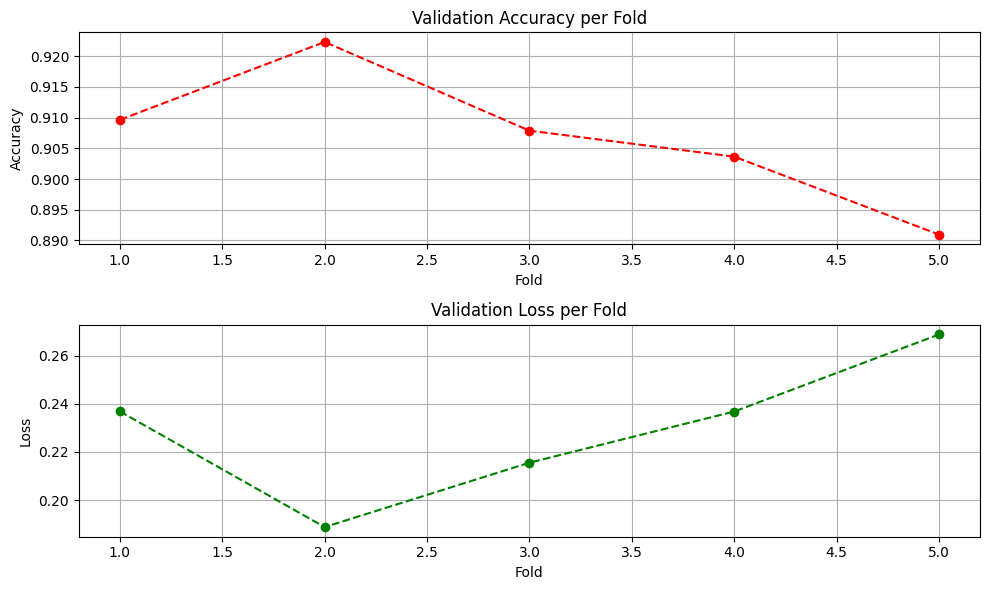

In [88]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(range(1, len(VALIDATION_ACCURACY) + 1), VALIDATION_ACCURACY, marker='o', linestyle='--', color='r')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(range(1, len(VALIDATION_LOSS) + 1), VALIDATION_LOSS, marker='o', linestyle='--', color='green')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()